# GUI performance using an rSNAPed simulation as ground truth.
___

In [1]:
import sys; from pathlib import Path; current_dir = Path().resolve()
src_dir = next(parent / 'src' for parent in Path().absolute().parents if (parent / 'src').is_dir())
sys.path.extend([str(src_dir), str(src_dir / 'pipelines')])
main_dir = Path(src_dir.parents[0])
from imports import * 


In [ ]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.style.use("dark_background")


    # Update rcParams to set a white background and Arial fonts.
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.5,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelcolor': 'black',
    'text.color': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.edgecolor': 'black',
    })

In [ ]:
rsnapsim_dir = r'/Users/nzlab-la/Desktop/rSNAPsim'
rsnaped_dir = r'/Users/nzlab-la/Desktop/rSNAPed'
gene_file = Path('/Users/nzlab-la/Desktop/micro/notebooks/GUI_paper_SI/pTM001 (pUB_smHA_KDM5B_MS2).dna')
rsnaped_settings_yaml = r'/Users/nzlab-la/Desktop/micro/notebooks/GUI_paper_SI/kdm5b.yaml'
results_dir = Path('/Users/nzlab-la/Desktop/micro/notebooks/GUI_paper_SI')

In [4]:
import os
homedir =r'/Users/nzlab-la/Desktop/rsnaped/notebooks_final'
os.chdir(homedir)
os.chdir(rsnapsim_dir)
import rsnapsim as rsnp
os.chdir(homedir)

# Defining directories
current_dir = pathlib.Path(rsnaped_dir).absolute()
sequences_dir = current_dir.joinpath('DataBases','gene_files')
video_dir = current_dir.joinpath('DataBases','videos_for_sim_cell')
masks_dir = current_dir.joinpath('DataBases','masks_for_sim_cell')

# Importing rSNAPed
sys.path.append(str(current_dir.joinpath('rsnaped')))
import rsnaped as rsed


[]



In [5]:
# Pick a base cell to simulate from
cell_num = np.random.randint(0,7)
cell_num = 3
video = imread(video_dir.joinpath('cell_shape_'+str(cell_num)+'.tif'))
mask_image = imread(masks_dir.joinpath('mask_cell_shape_'+str(cell_num)+'.tif'))

# Cell simulation parameters
___

In [ ]:
n_spots = 80# np.random.randint(70,80)
framerate = 5
t = np.array(range(0,1800+framerate,framerate)) # 0 to 1800s with 5s framerate


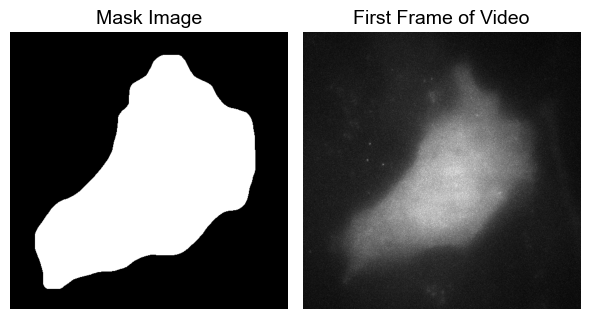

In [88]:
# # plot mask image and first frame of video
show_mask_image = False
if show_mask_image := True:
    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
    ax[0].imshow(mask_image, cmap='gray')
    ax[0].set_title('Mask Image')
    ax[0].axis('off')
    ax[1].imshow(video[0,:,:,0], cmap='gray')
    ax[1].set_title('First Frame of Video')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

Gene length: 1910 bp
ki: 0.04, ke_mu: 10


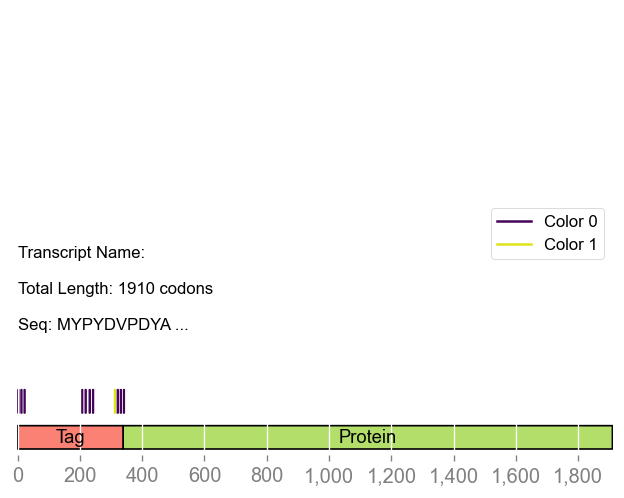

In [85]:

# Run simulation or load the simulated cell 
run_simulation = False
if run_simulation == True:
    # Making the simulated cell class off of the kdm5b yaml
    simulated_cell_KDM5B = rsed.SimCell2D(video, mask_image, rsnaped_settings_yaml)
    # overwrite mRNA 1, manually overwrite the kdm5b yaml with the correct CDS since by default it uses the first largest CDS.
    _,_,tagged_CDSs,_ = rsnp.seqmanip.open_seq_file(str(gene_file), add_tag=False)
    KDM5B = tagged_CDSs['-1'][0]
    #set the correct ki, ke from the yaml
    KDM5B.ki = simulated_cell_KDM5B.mRNAs[0].mRNAs['parameters'][0]
    KDM5B.ke_mu = simulated_cell_KDM5B.mRNAs[0].mRNAs['parameters'][1]
    simulated_cell_KDM5B.mRNAs[0].mRNA_model = KDM5B #mRNA species 0's model = this new poi
    KDM5B.visualize_mrna_strand()
    gene_length = tagged_CDSs['-1'][0].CDS_length
    print(f"Gene length: {tagged_CDSs['-1'][0].CDS_length} bp")
    # print the simulation parameters
    print(f"ki: {KDM5B.ki}, ke_mu: {KDM5B.ke_mu}")
    # randomizing diffusion rates a bit
    simulated_cell_KDM5B.D = np.random.rand(n_spots)*3 + np.random.rand(n_spots)
    video_array, simulated_intensity, spot_positions = simulated_cell_KDM5B.gen(n_spots, t, verbose=1, disk_buffer=False, buffer_size=25) #generate a video
    simulated_cell_KDM5B.mRNAs[0].mRNAs['parameters']
    #save the tif and intensity/spot positions
    rsed.Util.write_video_to_tif(video_array, results_dir.joinpath('smHA-KDM5B.tif'), TimeIncrement=framerate)
    np.savez(results_dir.joinpath('simulated_intensity.npz'), simulated_intensity)
    np.savez(results_dir.joinpath('spot_positions.npz'), spot_positions)

else:
    # Load the simulated cell
    video_array = imread(results_dir.joinpath('smHA-KDM5B.tif'))
    simulated_intensity = np.load(results_dir.joinpath('simulated_intensity.npz'))['arr_0']
    spot_positions = np.load(results_dir.joinpath('spot_positions.npz'))['arr_0']
    simulated_cell_KDM5B = rsed.SimCell2D(video_array, mask_image, rsnaped_settings_yaml)
    simulated_cell_KDM5B.mRNAs[0].mRNAs['parameters']
    _,_,tagged_CDSs,_ = rsnp.seqmanip.open_seq_file(str(gene_file), add_tag=False)
    KDM5B = tagged_CDSs['-1'][0]
    #set the correct ki, ke from the yaml
    KDM5B.ki = simulated_cell_KDM5B.mRNAs[0].mRNAs['parameters'][0]
    KDM5B.ke_mu = simulated_cell_KDM5B.mRNAs[0].mRNAs['parameters'][1]
    simulated_cell_KDM5B.mRNAs[0].mRNA_model = KDM5B #mRNA species 0's model = this new poi
    KDM5B.visualize_mrna_strand()
    gene_length = tagged_CDSs['-1'][0].CDS_length
    print(f"Gene length: {tagged_CDSs['-1'][0].CDS_length} bp")
    # print the simulation parameters
    print(f"ki: {KDM5B.ki}, ke_mu: {KDM5B.ke_mu}")


In [ ]:

show_animated_video = False

if show_animated_video == True:
    maxes = np.array([video_array[...,i].max() for i in [0,1,2]])
    maxes[2] = 14000  # if you want to override channel 2 max
    fig, ax = plt.subplots(figsize=(5,5))
    ax.axis('off')
    ax.grid(False)
    # initialize the image artist
    im = ax.imshow(video_array[0] / maxes, animated=True)
    def animate(frame):
        im.set_data(video_array[frame] / maxes)
        return (im,)
    ani = animation.FuncAnimation(
        fig, 
        animate, 
        frames=len(video_array), 
        interval=50,    # ms between frames
        blit=True
    )
    # prevent the static figure from displaying
    plt.close(fig)
    # this is the only output: the video player
    HTML(ani.to_html5_video())
    #save the movie if you want
    writer = animation.writers['ffmpeg'](fps=12, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(results_dir.joinpath('smHA-kdm5b.mp4'), writer=writer)

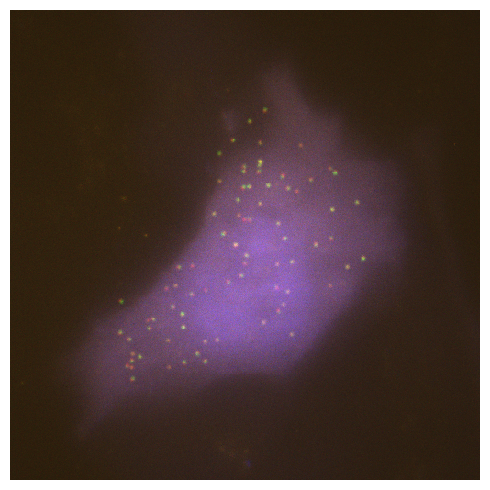

In [163]:
# compute per‐channel maxima from the whole movie
maxes = np.array([video_array[..., i].max() for i in [0,1,2]])
maxes[2] = 14000  # override channel 2 max if you like

frame0 = video_array[0, 0]  # (Y, X, C)

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(frame0 / maxes, interpolation='nearest')
ax.axis('off')
ax.grid(False)
plt.tight_layout()
plt.show()
# save the image as a PNG
fig.savefig(results_dir.joinpath('smHA-kdm5b_frame0.png'), dpi=900, bbox_inches='tight', pad_inches=0.1)

In [142]:
video_array.shape

(361, 1, 512, 512, 3)

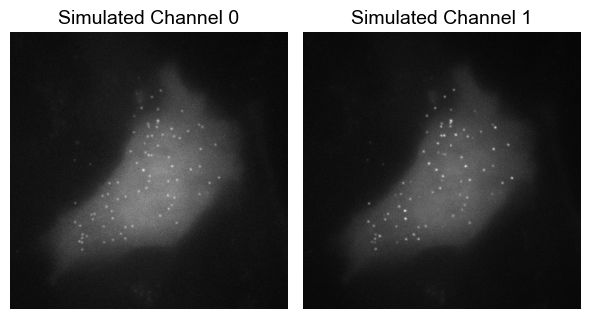

In [146]:
# plot the simulated video frame 0 channel 0 and channel 1
if show_mask_image == True:
    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
    ax[0].imshow(video_array[0,0,:,:,0], cmap='gray')
    ax[0].set_title('Simulated Channel 0')
    ax[0].axis('off')
    ax[1].imshow(video_array[0,0,:,:,1], cmap='gray')
    ax[1].set_title('Simulated Channel 1')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

Text(0, 0.5, 'Intensity (a.u.)')

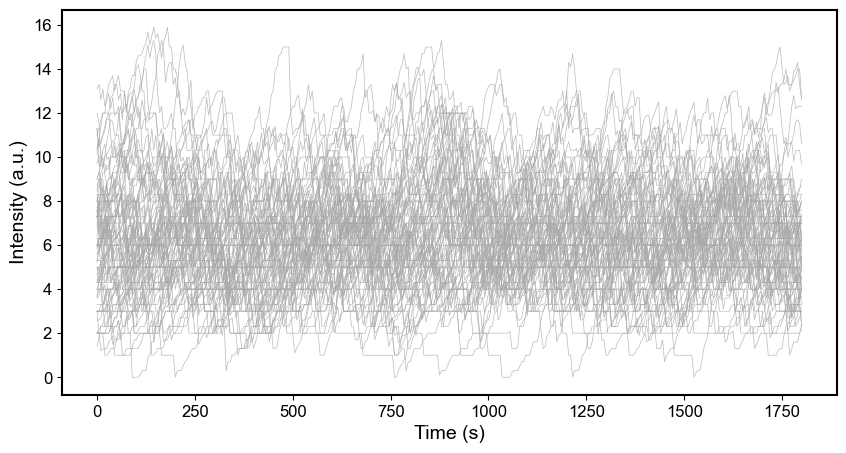

In [ ]:
# plot the simulated intensity
fig, ax = plt.subplots(figsize=(10,5))
for i in range(simulated_intensity.shape[0]):
    #ax.plot(t, simulated_intensity[i,:,0].T, label='Channel 1', color='red')
    ax.plot(t, simulated_intensity[i,:,1].T, label='Channel 2', color='darkgray', alpha=0.8, linewidth=0.5)
    #ax.plot(t, simulated_intensity[i,:,2].T, label='Channel 3'  , color='blue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Intensity (a.u.)')

In [16]:
simulated_intensity_data = simulated_intensity[:,:,1]
print(f"Simulated data shape: {simulated_intensity_data.shape}"   , " [sample,time] ") 

Simulated data shape: (80, 361)  [sample,time] 


In [190]:
def plot_correlation_comparison(mean_correlation, std_correlation, lags,
                                mean_correlation_ssa=None, std_correlation_ssa=None, lags_ssa=None,  
                                plot_name='temp', start_lag=1, y_axes_min_max_list_values=None,
                                x_axes_min_max_list_values=None, show_legend=True, ke=None, ki=None):



    # Create the figure and axes.
    fig, ax = plt.subplots(figsize=(5, 3), facecolor='white')

    # convert lags to min by dividing by 60
    
    #lags = lags / 60
    #if lags_ssa is not None:
    #    lags_ssa = lags_ssa / 60

    # Automatically determine the maxlag
    maxlag = len(lags)
    maxlag_ssa = len(lags_ssa) if lags_ssa is not None else 0

    # Create legend label with ke and ki values
    legend_label_exp = 'Micro (mean)'
    legend_label_sim = (fr'rSNAPEd ($k_e$={np.round(ke,1)}, $k_i$={np.round(ki,3)})' 
                    if ke is not None and ki is not None else 'Simulation')
    # Plot the experimental correlation (blue).
    ax.plot(lags[start_lag:maxlag], mean_correlation[start_lag:maxlag],
            'o-', color='blue', linewidth=1, label=legend_label_exp, markersize=7)
    ax.fill_between(lags[start_lag:maxlag],
                    mean_correlation[start_lag:maxlag] - std_correlation[start_lag:maxlag],
                    mean_correlation[start_lag:maxlag] + std_correlation[start_lag:maxlag],
                    color='blue', alpha=0.1)

    if mean_correlation_ssa is not None:
        # Plot the simulation correlation (red).
        ax.plot(lags_ssa[start_lag:maxlag_ssa], mean_correlation_ssa[start_lag:maxlag_ssa],
                '-', color='red', linewidth=4, label=legend_label_sim)
        ax.fill_between(lags_ssa[start_lag:maxlag_ssa],
                        mean_correlation_ssa[start_lag:maxlag_ssa] - std_correlation_ssa[start_lag:maxlag_ssa],
                        mean_correlation_ssa[start_lag:maxlag_ssa] + std_correlation_ssa[start_lag:maxlag_ssa],
                        color='red', alpha=0.1)

    # Add a legend.
    if show_legend:
        ax.legend(loc='upper right')

    # Set axis limits.
    if x_axes_min_max_list_values is not None:
        ax.set_xlim(x_axes_min_max_list_values[0], x_axes_min_max_list_values[1])

    if y_axes_min_max_list_values is not None:
        ax.set_ylim(y_axes_min_max_list_values[0], y_axes_min_max_list_values[1])

    # Set axis labels and title.
    ax.set_xlabel(r'$\tau (sec)$', fontsize=14)
    ax.set_ylabel(r'$G(\tau)$', fontsize=14)

    # Customize spines
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    # ensure the ticks are interger
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Ensure layout is tight and save figure
    plt.tight_layout()
    #plt.savefig('comparison_ACF_' + plot_name + '.png', dpi=600)
    plt.savefig(results_dir.joinpath('ACF.png'), dpi=900)
    #plt.savefig(results_folder.joinpath('ACF_model_data_'+plot_name+'.svg'), dpi=600)

    plt.show()

Baseline correction is enabled. Plotting individual trajectories is disabled due to baseline correction.
dwell_time: None


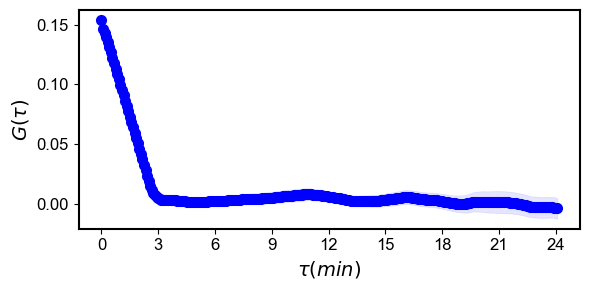

In [ ]:

mean_correlation_ssa, std_correlation_ssa, lags, correlations_array, dwell_time = mi.Correlation(primary_data=simulated_intensity_data,
                                                                                    max_lag=max_lag, 
                                                                                    nan_handling='forward_fill',  #forward_fill, 'ignore'
                                                                                    shift_data=True,
                                                                                    return_full=False,
                                                                                    time_interval_between_frames_in_seconds=framerate,
                                                                                    use_bootstrap=True,
                                                                                    show_plot=False,
                                                                                    start_lag=0,
                                                                                    fit_type='linear',
                                                                                    de_correlation_threshold=0.005,
                                                                                    index_max_lag_for_fit = 45,
                                                                                    correct_baseline=True,
                                                                                    use_linear_projection_for_lag_0=True,
                                                                                    save_plots=False,
                                                                                    use_global_mean= False,
                                                                                    remove_outliers = remove_outliers,
                                                                                    MAD_THRESHOLD_FACTOR = MAD_THRESHOLD_FACTOR,
                                                                                    plot_individual_trajectories = False,
                                                                                    y_axes_min_max_list_values = None, #y_axes_min_max_list_values,
                                                                                    x_axes_min_max_list_values=x_axes_min_max_list_values,
                                                                                    plot_title=None).run()

print("dwell_time:", dwell_time)

# plot the ACF
#plot_correlation_comparison(mean_correlation_ssa, std_correlation_ssa, lags, plot_name=None, start_lag=0, show_legend = False, y_axes_min_max_list_values = y_axes_min_max_list_values,x_axes_min_max_list_values=x_axes_min_max_list_values)

Dwell index: 35 frames, 175 seconds
g0: 0.15231886408651574
Calculated ke: 10.914285714285715, ki: 0.03751528576946354


In [164]:
# # plot the intensity distribution at the first frame
# fig, ax = plt.subplots(figsize=(5, 3), facecolor='white')
# number_bins = 30
# ax.hist(simulated_intensity_data[:,0], bins=number_bins, color='gray', alpha=0.5)
# ax.set_xlabel('Intensity (a.u.)')
# ax.set_ylabel('Frequency')
# ax.set_title('Intensity Distribution at Frame 0')
# ax.set_xlim(-0.5, np.max(simulated_intensity_data[:,0]) * 1.1) 
# ax.set_ylim(0, np.max(np.histogram(simulated_intensity_data[:,0], bins=number_bins)[0]) * 1.1)
# for spine in ax.spines.values():
#     spine.set_edgecolor('black')
#     spine.set_linewidth(1.5)
#     plt.tight_layout()


# Loading GUI data
___

In [ ]:
# Loading the GUI data to compare with the simulated data.
gui_tracking_df = pd.read_csv(results_dir.joinpath('results_smHA-KDM5B_smHA-KDM5B','tracking_smHA-KDM5B_smHA-KDM5B.csv'))


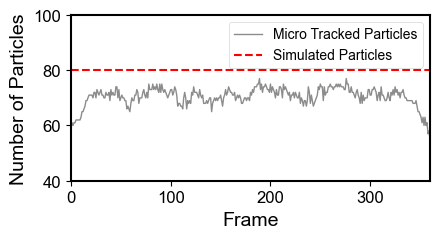

In [182]:
# load the number of particles detected at each frame
n_particles_per_frame = gui_tracking_df.groupby('frame').size().values
# plot the number of particles detected at each frame
fig, ax = plt.subplots(figsize=(4.5, 2.5), facecolor='white')
ax.plot(n_particles_per_frame, color='gray', alpha=0.9, linewidth=1, label='Micro Tracked Particles')
# plot a horizontal line at the mean number of particles used for the simulation. n_spots
ax.axhline(y=n_spots, color='red', linestyle='--', label=f'Simulated Particles')
ax.set_xlabel('Frame', fontsize=14)
ax.set_ylabel('Number of Particles', fontsize=14)
ax.legend(loc='upper right')
#ax.set_title('Number of Particles')
ax.set_xlim(0, len(n_particles_per_frame) - 1)
ax.set_ylim(40, 100)
# save the figure
plt.tight_layout()
plt.savefig(results_dir.joinpath('n_particles_per_frame.png'), dpi=900)

In [96]:
# extract the psf_sigma_ch_1 for all particles in all frames
psf_sigma_ch_1_gui = gui_tracking_df['psf_sigma_ch_1'].values
# remove nan values
psf_sigma_ch_1_gui = psf_sigma_ch_1_gui[~np.isnan(psf_sigma_ch_1_gui)]
# calculate the mean and std

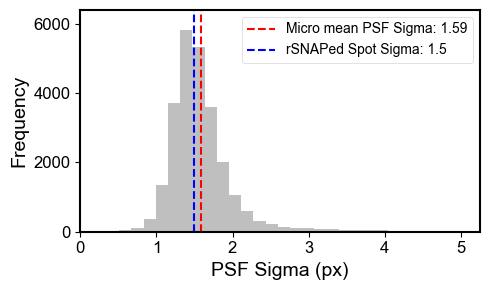

In [166]:
gui_tracking_df.columns

use_spot_sigma = 1.5
ymax_hist =  np.max(np.histogram(psf_sigma_ch_1_gui, bins=number_bins)[0]) * 1.1
# extract the spot_int_ch_1 values for all particles in the first frame
# plot an histiogram of the intensity at frame 0
fig, ax = plt.subplots(figsize=(5, 3), facecolor='white')
ax.hist(psf_sigma_ch_1_gui, bins=number_bins, color='grey', alpha=0.5)
ax.set_xlabel('PSF Sigma (px)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
#ax.set_title('PSF Sigma')
ax.set_xlim(0, np.max(psf_sigma_ch_1_gui) * 1.05) 
ax.set_ylim(0, ymax_hist)
# print a vertical line at the use_spot_sigma as a red line with max y values  np.max(psf_sigma_ch_1_gui) * 1.1
ax.axvline(np.mean(psf_sigma_ch_1_gui),ymax=ymax_hist, color='red', linestyle='--', label=f'Micro mean PSF Sigma: {np.mean(psf_sigma_ch_1_gui):.2f}')
ax.axvline(use_spot_sigma ,ymax=ymax_hist, color='b', linestyle='--', label=f'rSNAPed Spot Sigma: {use_spot_sigma}')
ax.legend()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
plt.tight_layout()
# save the figure
plt.savefig(results_dir.joinpath('psf_sigma_ch_1_histogram.png'), dpi=900)

In [ ]:
step_size_in_sec = 5
start_lag = 0
remove_outliers = True
selected_field = 'spot_int_ch_1'  # spot_int_ch_0, psf_amplitude_ch_0, snr_ch_0,
downsample = False
downsampling_factor = 2
MAD_THRESHOLD_FACTOR = 4
min_percentage_data_in_trajectory = 0.3
max_lag = None

In [ ]:
def extract_intensity_and_shift_data (dataframe, selected_field = 'spot_int_ch_0', min_percentage_data_in_trajectory = 0.4, padd_with_nans = True, maximum_columns = 360,max_missing_frames=3):
    intensity_array = mi.Utilities().df_trajectories_to_array(dataframe=dataframe, selected_field=selected_field, fill_value='nans')
    intensity_array_shifted = mi.Utilities().shift_trajectories(intensity_array,min_percentage_data_in_trajectory=min_percentage_data_in_trajectory,max_missing_frames=max_missing_frames)
    number_of_columns = intensity_array_shifted.shape[1]
    if padd_with_nans:        
        if number_of_columns < maximum_columns:
            intensity_array_shifted = np.pad(intensity_array_shifted, ((0,0),(0,maximum_columns-number_of_columns)), mode='constant', constant_values=np.nan)
    if number_of_columns > maximum_columns:
        intensity_array_shifted = intensity_array_shifted[:,0:maximum_columns]
    return intensity_array_shifted

gui_intensity_array = extract_intensity_and_shift_data(gui_tracking_df, selected_field=selected_field,min_percentage_data_in_trajectory=min_percentage_data_in_trajectory)


In [77]:

gui_mean_correlation, gui_std_correlation, lags, _, _ = mi.Correlation(primary_data=gui_intensity_array,
                                                                                    max_lag=max_lag, 
                                                                                    nan_handling='forward_fill',  #forward_fill, 'ignore'
                                                                                    shift_data=True,
                                                                                    return_full=False,
                                                                                    time_interval_between_frames_in_seconds=framerate,
                                                                                    use_bootstrap=True,
                                                                                    show_plot=False,
                                                                                    start_lag=0,
                                                                                    fit_type='linear',
                                                                                    de_correlation_threshold=0.005,
                                                                                    index_max_lag_for_fit = 45,
                                                                                    correct_baseline=True,
                                                                                    use_linear_projection_for_lag_0=True,
                                                                                    save_plots=False,
                                                                                    use_global_mean= False,
                                                                                    remove_outliers = remove_outliers,
                                                                                    MAD_THRESHOLD_FACTOR = MAD_THRESHOLD_FACTOR,
                                                                                    plot_individual_trajectories = False,
                                                                                    y_axes_min_max_list_values = None, #y_axes_min_max_list_values,
                                                                                    x_axes_min_max_list_values=x_axes_min_max_list_values,
                                                                                    plot_title=None).run()

print("dwell_time:", dwell_time)

Baseline correction is enabled. Plotting individual trajectories is disabled due to baseline correction.
dwell_time: None


In [ ]:
data_lags = lags_ssa = t

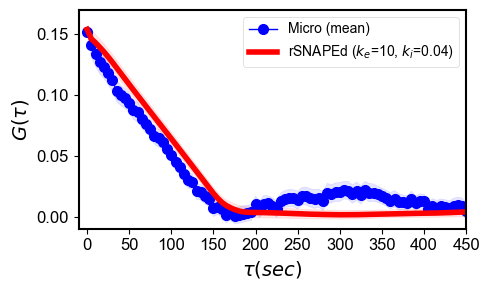

In [198]:
y_axes_min_max_list_values =  [-0.01, 0.17]
x_axes_min_max_list_values = [-10, 450]

plot_correlation_comparison(gui_mean_correlation, gui_std_correlation, data_lags,
                            mean_correlation_ssa, std_correlation_ssa, lags_ssa, plot_name=None, start_lag=start_lag, 
                            y_axes_min_max_list_values = y_axes_min_max_list_values,
                            x_axes_min_max_list_values=x_axes_min_max_list_values,show_legend = True, ke=10, ki=0.04)


In [200]:
# calculate the dwell time when the correlation is below 0.1
dwell_index = np.where(gui_mean_correlation < 0.005)[0][0]
dwell_time = dwell_index * framerate
print(f"Dwell index: {dwell_index} frames, {dwell_time} seconds")

g0 = gui_mean_correlation[0]
print(f"g0: {g0}")

# calculate the ke and ki from the dwell time
ke = gene_length / dwell_time
ki = 1/ (dwell_time * g0)  # assuming ki is half
print(f"Calculated ke: {ke}, ki: {ki}")

Dwell index: 33 frames, 165 seconds
g0: 0.15170212881150666
Calculated ke: 11.575757575757576, ki: 0.039950698833873984


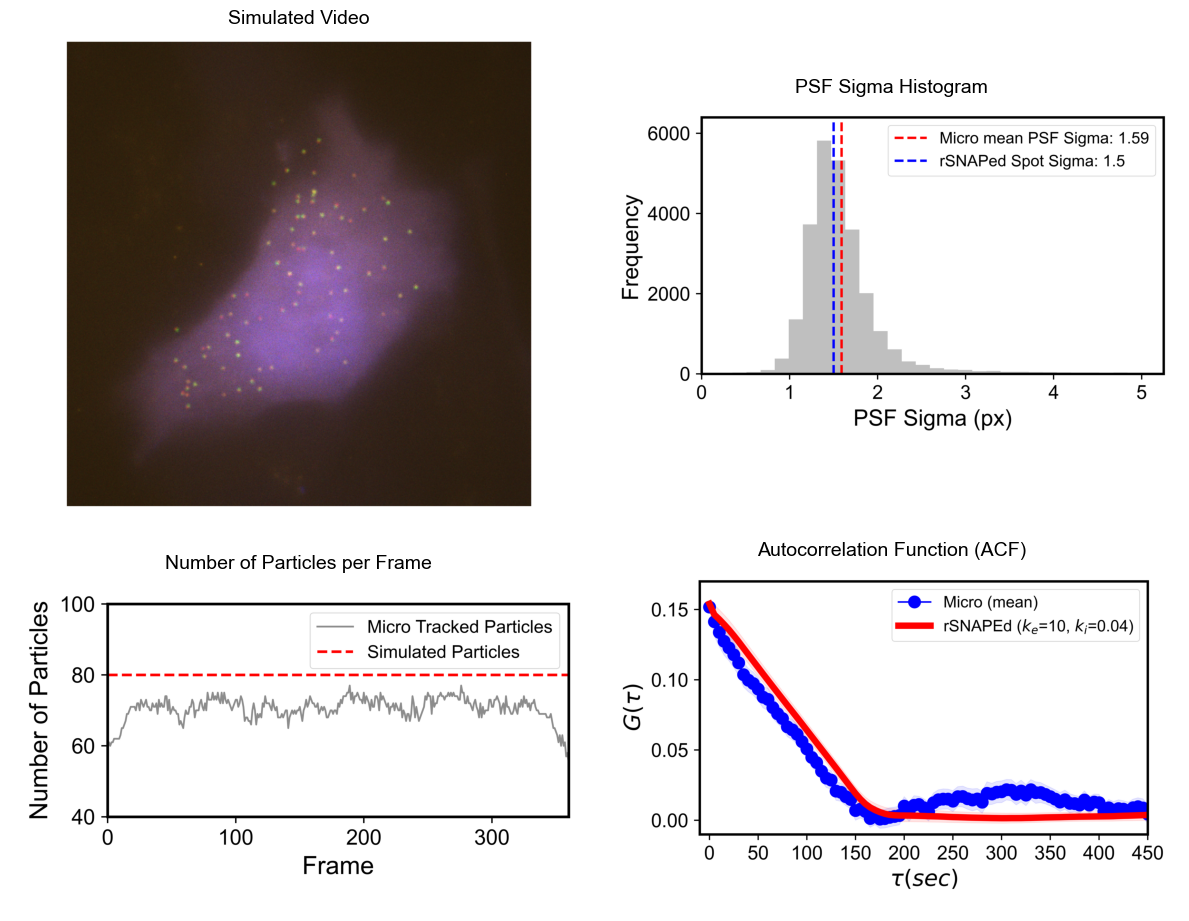

Combined figure saved to /Users/nzlab-la/Desktop/micro/notebooks/GUI_paper_SI/figure_synthetic_data.png


In [199]:

import matplotlib.image as mpimg

filenames = [
    'smHA-kdm5b_frame0.png',
    'psf_sigma_ch_1_histogram.png',
    'n_particles_per_frame.png',
    'ACF.png'
]

titles = [
    'Simulated Video',
    'PSF Sigma Histogram',
    'Number of Particles per Frame',
    'Autocorrelation Function (ACF)'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
index=0
for ax, fname in zip(axes, filenames):
    img = mpimg.imread(str(results_dir / fname))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(titles[index], fontsize=14)
    index += 1
    #ax.set_title(titles , fontsize=14)

plt.tight_layout()
plt.show()

# Save the combined figure
combined_fig_path = results_dir.joinpath('figure_synthetic_data.png')
fig.savefig(combined_fig_path, dpi=900, bbox_inches='tight', pad_inches=0.1)
print(f"Combined figure saved to {combined_fig_path}")